This jupyter notebook contains the data analysis code used for my [medium.com blogpost](https://medium.com/@renju.s.mathew/the-stackoverflow-yearly-survey-a-treasure-trove-of-insight-938aa4ac46b3).

This project follows the **CRISP-DM** (Cross-industry standard process for data mining) Process. The following steps will be described in the relevant parts of the notebook:

**1. Business Understanding**: We are analysing yearly StackOverFlow survey data to identify trends of interest to developers.

**2. Data Understanding**: Trends in the survey data related to Gender, Race, and Popular Programming Languages are analysed. 
The labelling of these varies from year to year so these categorical variables need to be handled carefully.

**3. Data Preparation**: Data preparation steps are outlined in the notebook.

**4. Modelling**: No machine learning was performed. Visualisations for the interesting trends were saved as .png files.

**5. Evaluation & 6. Deployment**: This is done in the [medium.com](https://medium.com/@renju.s.mathew/938aa4ac46b3) article.



<b>Contents of notebook</b>

Steps of the data science process:

- [Gather](#Gather)

- [Assess](#Assess)

- (Gender)
  - [Clean](#CleanGender)
  - [Analyse](#AnalyseGender)
  - [Visualise](#VisualiseGender)
   - Figure 2. The (lack of) change in gender representation between the years 2017– 2021.
- (Race)
  - [Clean](#CleanRace)
  - [Analyse](#AnalyseRace)
  - [Visualise](#VisualiseRace)
   - Figure 3. The change in the representation of ethnicities between the years 2017– 2021.
- (Popular Programming Languages)
  - [Clean](#CleanLanguages)
  - [Analyse](#AnalyseLanguages)
  - [Visualise](#VisualiseLanguages)
     - Figure 1. The most popular programming languages in the years 2017– 2021.
     - Table 1. Top 10 most popular programming languages Figure 1; years 2017 and 2021.

**CRISP-DM 1. Business Understanding**

- We will analyse the survey data provided by [StackOverFlow](https://insights.stackoverflow.com/survey). 
- As survey data is collected each year, we can use the data to identify trends of interest to developers.
- The data for the last five years (2017 – 2021) contains over 380,000 individual responses.
- Trends in the survey data related to Gender, Race, and Popular Programming Languages are analysed, namely:
    - 1. How has the gender distribution of the survey participants changed between 2017 – 2021?
    - 2. How has the racial/ethnic distribution of the survey participants changed between 2017 – 2021?
    - 3. Which programming languages have become more or less popular between 2017 – 2021?

In [1]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

## Functions

In [2]:
# A convenience function
import inspect
def retrieve_name(var):
    '''Retrieves the name of a variable
    
    This is a modified version of the function provided by user scohe001 here:
    https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string
    '''
    local_vars = inspect.currentframe().f_back.f_locals.items() # Variable in the local namespace seen by this frame
    return [var_name for var_name, var_val in local_vars if var_val is var]

In [3]:
from collections import defaultdict
def total_count(df, col1, col2, look_for):
    '''
    OUTPUT:
    new_df - a dataframe of each "look_for" with the count of how often it appears 
    
    INPUT:
    df - pandas dataframe
    col1 - column name to look through
    col2 - column to count values from
    look_for - a list of strings to search for in each row of df[col]

    This is a modified function from that provided in udacity data science nanodegree
    '''
    new_df = defaultdict(int)

    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the val is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [4]:
def get_possible_values(df, column_name, verbose = False):
    '''Returns set of all the distinct values in a pandas column'''
    all_values = df[column_name].values.tolist()
    all_values = [x for x in all_values if str(x) != 'nan'] # Ensures nan values are handled correctly
    list_of_lists = []
    for a_value in all_values:
        #list_of_lists.append([s.strip() for s in a_value.replace(',', ';').split(';')]) # Uncomment to treat semicolon as separator
        list_of_lists.append([s.strip() for s in a_value.split(';')])
    flat_list = [item for sublist in list_of_lists for item in sublist]
    if verbose: print(set(flat_list))
    return set(flat_list)

In [5]:
def clean_and_plot(df, column_name, possible_values, title='', plot=True):
    '''
    OUTPUT
    props_study_df - a dataframe with the proportion of counts for values in the column_name column.
    Displays a plot of the proportion of counts for values in the column_name column.
        
    INPUT 
    df - a dataframe holding the column of interest
    possible_values - set of all the possible values in column of interest
    
    This is a modified function from that provided in udacity data science nanodegree
    '''
    
    study = df[column_name].value_counts().reset_index()
    study.rename(columns={'index': column_name, column_name: 'count'}, inplace=True)
    study_df = total_count(study, column_name, 'count', possible_values)

    study_df.set_index(column_name, inplace=True)
    if plot:
        (study_df/study_df.sum()).plot(kind='bar', legend=None, figsize = ((10,5)));
        plt.title(title);
        plt.show()
    props_study_df = study_df/study_df.sum()
    return props_study_df

In [6]:
loc = "G:\\My Drive\\udacity\\nd025-nanodegree-data-science\\PROJECTS_FOR_SUBMISSION\\Project1-Write_A_Data_Science_Blog_Post\\data\\" # Insert location here

<a name="DataWrangling"></a>

<a name="Gather"></a>
## Gather data

**CRISP-DM 2. Data Understanding** 

The csv files for 2017--2021 are downloaded from the https://insights.stackoverflow.com/survey

For the data csv file for each year, there is a "schema" csv files that gives more description of each column in the data csv.

As we are only analysing data related to Gender, Race, and Popular Programming Languages, we can discard most of the columns.

We find from inspection of the column names reveals that the labelling of columns related to Gender, Race, and Popular Programming Languages vary from year to year, so we will have to look through the column names (and check the schema if required) to choose the correct columns.  

All of these files are just small enough to be viewable on a spreadsheet program. I found it convenient to use Excel to open these files to visually assess them.

In [7]:
# Load in data
all_data = []
all_schema = []
for i in range(2017,2022,1):
    all_data.append(pd.read_csv(loc+str(i)+'survey_results_public.csv', dtype=object))
    all_schema.append(pd.read_csv(loc+str(i)+'survey_results_schema.csv'))

In [8]:
# Give data human readable aliases 
df2017 = all_data[0]; schema2017 = all_schema[0]
df2018 = all_data[1]; schema2018 = all_schema[1]
df2019 = all_data[2]; schema2019 = all_schema[2]
df2020 = all_data[3]; schema2020 = all_schema[3]
df2021 = all_data[4]; schema2021 = all_schema[4]

<a name="Assess"></a>
## Assess data

In [9]:
# Print out the shapes of all the dataframes
total_rows = 0
for dataframe in all_data:
    total_rows = total_rows + int(dataframe.shape[0])
    print(retrieve_name(dataframe)[0], dataframe.shape)
print("Total number of responses: ", total_rows)

df2017 (51392, 154)
df2018 (98855, 129)
df2019 (88883, 85)
df2020 (64461, 61)
df2021 (83439, 48)
Total number of responses:  387030


In [10]:
# Let us have a quick look at the data...

In [11]:
df2017.head()  

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
schema2017.head()  

,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to ope...
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree..."


In [13]:
df2018.head()  

,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
4,7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


In [14]:
schema2018.head()  

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,Hobby,Do you code as a hobby?
2,OpenSource,Do you contribute to open source projects?
3,Country,In which country do you currently reside?
4,Student,"Are you currently enrolled in a formal, degree..."


In [15]:
df2019.head()  

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


In [16]:
schema2019.head()  

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,MainBranch,Which of the following options best describes ...
2,Hobbyist,Do you code as a hobby?
3,OpenSourcer,How often do you contribute to open source?
4,OpenSource,How do you feel about the quality of open sour...


In [17]:
df2020.head()  

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [18]:
schema2020.head() 

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,MainBranch,Which of the following options best describes ...
2,Hobbyist,Do you code as a hobby?
3,Age,What is your age (in years)? If you prefer not...
4,Age1stCode,At what age did you write your first line of c...


In [19]:
df2021.head()  

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,...,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,...,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,...,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,NaN,Appropriate in length,Easy,NaN


In [20]:
schema2021.head() 

,qid,qname,question,force_resp,type,selector
0,QID16,S0,"<div><span style=""font-size:19px;""><strong>Hel...",False,DB,TB
1,QID12,MetaInfo,Browser Meta Info,False,Meta,Browser
2,QID1,S1,"<span style=""font-size:22px; font-family: aria...",False,DB,TB
3,QID2,MainBranch,Which of the following options best describes ...,True,MC,SAVR
4,QID24,Employment,Which of the following best describes your cur...,False,MC,MAVR


**CRISP-DM 3. Data Preparation** 

As we will not be performing any machine learning, nor creating any inferential statistics (i.e., there will be no modelling which would be CRISP-DM 4.), we shall use the function in the next cell to drop the rows containing null values.

For Gender and Race, the possible values these can take changes each year so these categorical variables need to be handled carefully: We will bundle certain values into the category of "Other".

More detail about each data preparation steps are outlined in what follows in the form of comments and markdown cells.

In [21]:
def drop_empty_rows(df):
    print("From " + str(df.shape[0]) +" rows ", end = '')
    print( df.isnull().any(axis=1).sum(), end = '') 
    print( " rows containing null values were dropped" , end = '')
    df = df.dropna() 
    print( ", leaving " + str(df.shape[0]) +" rows.")
    return df

However as we will be analysing Gender, Race and Popular Programming Languages separately, it makes sense *not* to remove until we subset the data below.

<a name="Gender"></a>
# Gender

1. How has the gender distribution of the survey participants changed between 2017 – 2021?

<a name="CleanGender"></a>
## Clean data

In [22]:
# Subset the data to only the columns we are analysing
df2017 = all_data[0][['Gender']]
df2018 = all_data[1][['Gender']]
df2019 = all_data[2][['Gender']]
df2020 = all_data[3][['Gender']]
df2021 = all_data[4][['Gender']]

In [23]:
# Remove missing values
df2017 = drop_empty_rows(df2017)
df2018 = drop_empty_rows(df2018)
df2019 = drop_empty_rows(df2019)
df2020 = drop_empty_rows(df2020)
df2021 = drop_empty_rows(df2021)

From 51392 rows 16345 rows containing null values were dropped, leaving 35047 rows.
From 98855 rows 34386 rows containing null values were dropped, leaving 64469 rows.
From 88883 rows 3477 rows containing null values were dropped, leaving 85406 rows.
From 64461 rows 13904 rows containing null values were dropped, leaving 50557 rows.
From 83439 rows 1153 rows containing null values were dropped, leaving 82286 rows.


In some years, a large number of rows are dropped, but it must be kept in mind that a much larger number of rows remain.

Let us first look at how gender distributions change over time.

In [24]:
print(get_possible_values(df2017, 'Gender'))
print(get_possible_values(df2018, 'Gender'))
print(get_possible_values(df2019, 'Gender'))
print(get_possible_values(df2020, 'Gender'))
print(get_possible_values(df2021, 'Gender'))

{'Female', 'Gender non-conforming', 'Other', 'Transgender', 'Male'}
{'Transgender', 'Male', 'Female', 'Non-binary, genderqueer, or gender non-conforming'}
{'Man', 'Woman', 'Non-binary, genderqueer, or gender non-conforming'}
{'Man', 'Woman', 'Non-binary, genderqueer, or gender non-conforming'}
{'Non-binary, genderqueer, or gender non-conforming', 'Prefer not to say', 'Or, in your own words:', 'Man', 'Woman'}


To handle this categorical variable, we note that the possible values for this variable change each year. Only "Male" and "Female" remain the same (though in some years these are sometimes labelled "Man" and "Woman".)

For this reason, we will be combining every entry that is neither Male nor Female into the Other category, so that differences over the years can be noted.

<a name="AnalyseGender"></a>
## Analyse data

### 2017

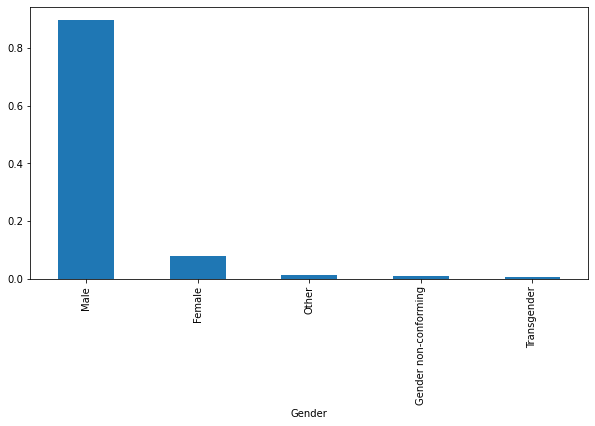

,count
Gender,
Female,0.077148
Male,0.896920
Other,0.025932


In [25]:
poss_gender_vals = get_possible_values(df2017, 'Gender')
props_df2017 = clean_and_plot(df2017, column_name = 'Gender', possible_values = poss_gender_vals)
#print(props_df2017.groupby(['Gender'], as_index=True).agg('sum'))
props_df2017.rename({'Transgender': 'Other', 'Non-binary': 'Other', 'Gender non-conforming': 'Other'}, inplace = True)
props_df2017 = props_df2017.groupby(['Gender'], as_index=True).agg('sum')
props_df2017

### 2018

{'Transgender', 'Male', 'Female', 'Non-binary, genderqueer, or gender non-conforming'}


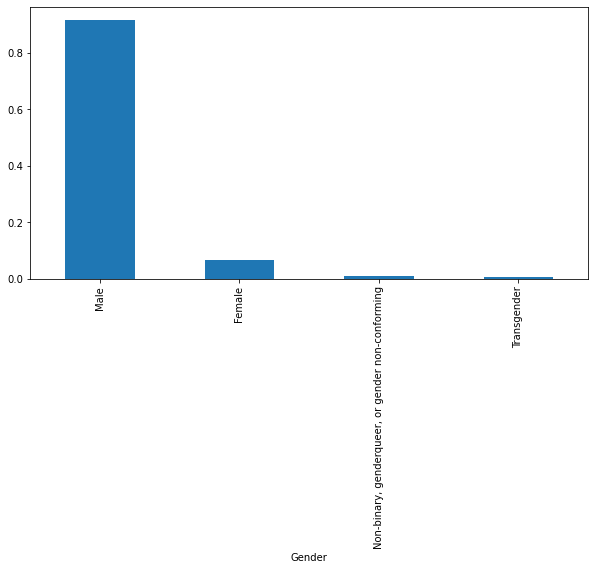

,count
Gender,
Female,0.067610
Male,0.916779
Other,0.015611


In [26]:
poss_gender_vals = get_possible_values(df2018, 'Gender', verbose = True)
props_df2018 = clean_and_plot(df2018, column_name = 'Gender', possible_values = poss_gender_vals)
props_df2018.rename({'Non-binary, genderqueer, or gender non-conforming': 'Other', 'Transgender': 'Other'}, inplace = True)
props_df2018 = props_df2018.groupby(['Gender'], as_index=True).agg('sum')
props_df2018

### 2019

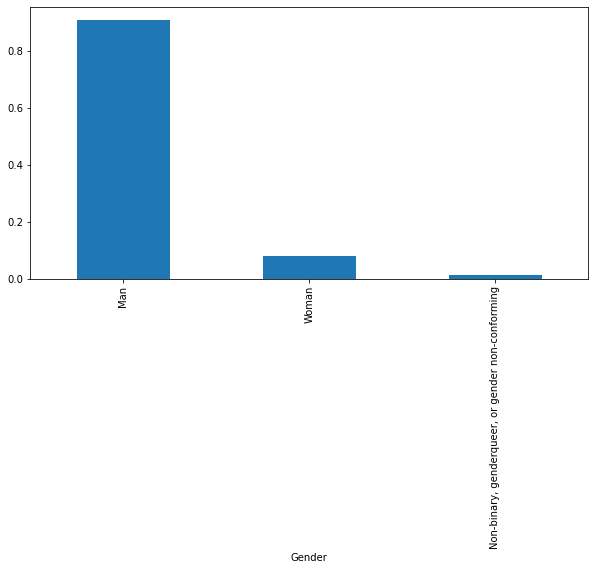

,count
Gender,
Female,0.077992
Male,0.910256
Other,0.011753


In [27]:
poss_gender_vals = get_possible_values(df2019, 'Gender')
props_df2019 = clean_and_plot(df2019, column_name = 'Gender', possible_values = poss_gender_vals)
props_df2019.rename({'Man': 'Male', 'Woman' : 'Female'}, inplace = True)
props_df2019.rename({'Non-binary, genderqueer, or gender non-conforming': 'Other'}, inplace = True)
props_df2019 = props_df2019.groupby(['Gender'], as_index=True).agg('sum')
props_df2019

### 2020

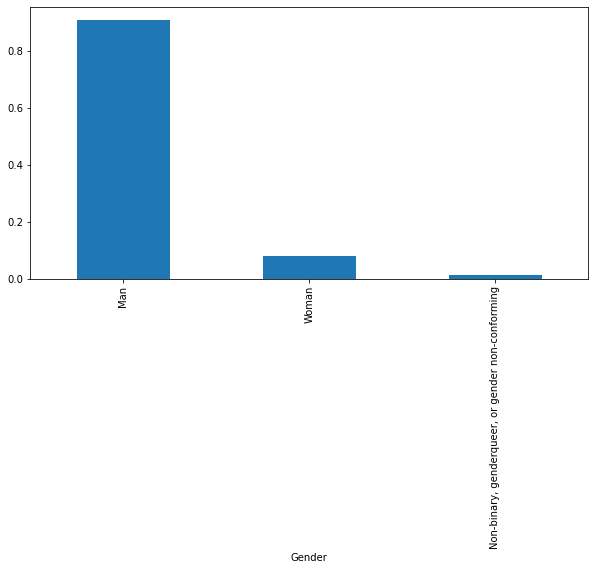

,count
Gender,
Female,0.079335
Male,0.908405
Other,0.012260


In [28]:
poss_gender_vals = get_possible_values(df2020, 'Gender')
props_df2020 = clean_and_plot(df2020, column_name = 'Gender', possible_values = poss_gender_vals)
props_df2020.rename({'Man': 'Male', 'Woman' : 'Female'}, inplace = True)
props_df2020.rename({'Non-binary, genderqueer, or gender non-conforming': 'Other'}, inplace = True)
props_df2020 = props_df2020.groupby(['Gender'], as_index=True).agg('sum')
props_df2020

### 2021

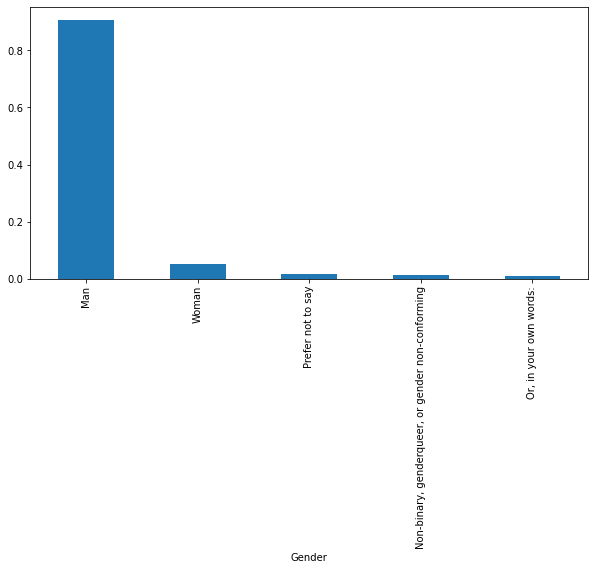

,count
Gender,
Female,0.052570
Male,0.906957
Other,0.040473


In [29]:
poss_gender_vals = get_possible_values(df2021, 'Gender')
props_df2021 = clean_and_plot(df2021, column_name = 'Gender', possible_values = poss_gender_vals)
props_df2021.rename({'Man': 'Male', 'Woman' : 'Female'}, inplace = True)
props_df2021.rename({'Non-binary, genderqueer, or gender non-conforming': 'Other', 
                     'Or, in your own words:': 'Other', 'Prefer not to say': 'Other'}
                    , inplace = True)
props_df2021 = props_df2021.groupby(['Gender'], as_index=True).agg('sum')
props_df2021

<a name="VisualiseGender"></a>
## Visualise gender data

In [30]:
props_df2017.rename(columns={"count": "2017"}, inplace = True)
props_df2018.rename(columns={"count": "2018"}, inplace = True)
props_df2019.rename(columns={"count": "2019"}, inplace = True)
props_df2020.rename(columns={"count": "2020"}, inplace = True)
props_df2021.rename(columns={"count": "2021"}, inplace = True)

In [31]:
counts_df = props_df2017.join(props_df2018)
counts_df = counts_df.join(props_df2019)
counts_df = counts_df.join(props_df2020)
counts_df = counts_df.join(props_df2021)

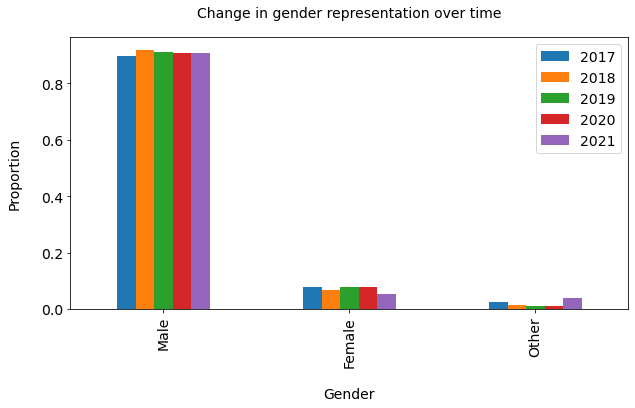

In [32]:
counts_df = counts_df.reindex(["Male", "Female", "Other"])
counts_df.plot(kind='bar', figsize = ((10,5)));
fontsize = 14
plt.legend(labels = [2017,2018,2019,2020,2021], fontsize = fontsize)
plt.xlabel('Gender', labelpad = 20, fontsize = fontsize)
plt.ylabel('Proportion', labelpad = 20, fontsize = fontsize)
plt.xticks(fontsize = fontsize); plt.yticks(fontsize = fontsize)
plt.title('Change in gender representation over time', fontsize = fontsize, pad = 20)
plt.show()

In [33]:
# Make a publication-quality plot for Gender

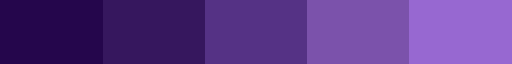

In [34]:
# Create custom palette
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
newcolors = np.array([[151, 104, 209],
[123, 82, 171],
[85, 50, 133],
[54, 23, 94],
[37, 6, 76]])/255
special_palette = ListedColormap(newcolors[::-1], name='special_palette')
special_palette

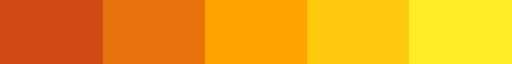

In [35]:
# Create custom palette
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
newcolors = np.array([[255, 236, 39],
[255, 201, 13],
[255, 163, 0],
[232, 115, 12],
[209, 73, 22],
])/255
gold_palette = ListedColormap(newcolors[::-1], name='special_palette')
gold_palette_reversed = ListedColormap(newcolors[::1], name='special_palette')
gold_palette

In [36]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

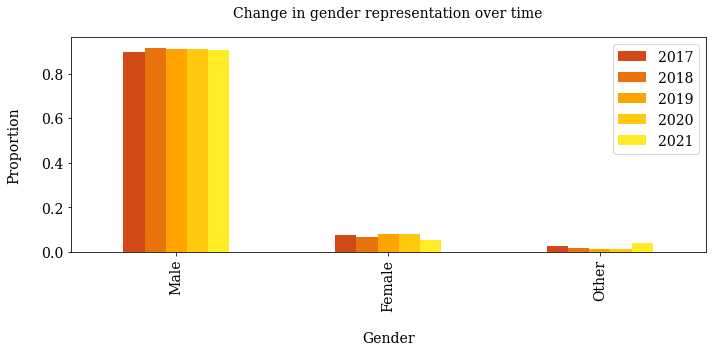

In [37]:
counts_df = counts_df.reindex(["Male", "Female", "Other"])
counts_df.plot(kind='bar', figsize = ((10,5)), colormap = gold_palette);
fontsize = 14
plt.legend(labels = [2017,2018,2019,2020,2021], fontsize = fontsize)
plt.xlabel('Gender', labelpad = 20, fontsize = fontsize)
plt.ylabel('Proportion', labelpad = 20, fontsize = fontsize)
plt.xticks(fontsize = fontsize); plt.yticks(fontsize = fontsize)
plt.title('Change in gender representation over time', fontsize = fontsize, pad = 20)
plt.tight_layout()
plt.savefig('Gender.png')
plt.show()

In [38]:
counts_df

,2017,2018,2019,2020,2021
Gender,,,,,
Male,0.896920,0.916779,0.910256,0.908405,0.906957
Female,0.077148,0.067610,0.077992,0.079335,0.052570
Other,0.025932,0.015611,0.011753,0.012260,0.040473


**CRISP-DM 5. Evaluation (Gender)** 

Remarkably, there has been almost no shift in the proportion in the "Male" category, which has stayed at almost 91% throughout.

There has been a slight decrease in the proportion in the "Female" category with a concomitant increase in the "Other" category.

<a name="Race"></a>
# Race/Ethnicity

2. How has the racial/ethnic distribution of the survey participants changed between 2017 – 2021?

<a name="CleanRace"></a>
## Clean Race/Ethnicity data

In [39]:
df2017 = drop_empty_rows(all_data[0][['Race']])
df2018 = drop_empty_rows(all_data[1][['RaceEthnicity']])
df2019 = drop_empty_rows(all_data[2][['Ethnicity']])
df2020 = drop_empty_rows(all_data[3][['Ethnicity']])
df2021 = drop_empty_rows(all_data[4][['Ethnicity']])

From 51392 rows 18359 rows containing null values were dropped, leaving 33033 rows.
From 98855 rows 41382 rows containing null values were dropped, leaving 57473 rows.
From 88883 rows 12215 rows containing null values were dropped, leaving 76668 rows.
From 64461 rows 18513 rows containing null values were dropped, leaving 45948 rows.
From 83439 rows 3975 rows containing null values were dropped, leaving 79464 rows.


In [40]:
# Moving on now to look at Race/Ethnicity

In [41]:
print(get_possible_values(df2017, 'Race'))
print(get_possible_values(df2018, 'RaceEthnicity'))
print((get_possible_values(df2019, 'Ethnicity')))
print(get_possible_values(df2020, 'Ethnicity'))
print(get_possible_values(df2021, 'Ethnicity'))

{'South Asian', 'East Asian', 'White or of European descent', 'Hispanic or Latino/Latina', 'Native American, Pacific Islander, or Indigenous Australian', 'I prefer not to say', 'Middle Eastern', 'I don’t know', 'Black or of African descent'}
{'South Asian', 'East Asian', 'White or of European descent', 'Hispanic or Latino/Latina', 'Native American, Pacific Islander, or Indigenous Australian', 'Middle Eastern', 'Black or of African descent'}
{'South Asian', 'Biracial', 'East Asian', 'Multiracial', 'White or of European descent', 'Hispanic or Latino/Latina', 'Native American, Pacific Islander, or Indigenous Australian', 'Middle Eastern', 'Black or of African descent'}
{'South Asian', 'Hispanic or Latino/a/x', 'Biracial', 'East Asian', 'Multiracial', 'White or of European descent', 'Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)', 'Middle Eastern', 'Southeast Asian', 'Black or of African descent'}
{'South Asian', 'Hispanic or Latino/a/x', 'Biracial', 'Pre

To handle this categorical variable, we note again that the possible values for this variable change each year. Only "Male" and "Female" remain the same (though in some years these are sometimes labelled "Man" and "Woman".)

Six categories have remained essentially the same throughout the years: 
East Asian
Hispanic or Latino/Latina 
South Asian
Black or of African descent
White or of European descent
Native American, Pacific Islander, or Indigenous Australian
Middle Eastern

However even with these there have been minor variations in the naming. These will need to be made consistent.

The following categories have come and gone throughout the years:
Biracial
Multiracial
Southeast Asian
I don't know
I prefer not to say
Or, in your own words:

All of these will be combined into "Other"

In [42]:
# Create an empty Other dataframe for later use
dfOther = pd.DataFrame([['RaceEthnicity', 'count'], ['Other', 0.0]])
dfOther.columns = dfOther.iloc[0] # Set first row as header
dfOther = dfOther[1:].set_index('RaceEthnicity') # Set first column as index
dfOther

,count
RaceEthnicity,
Other,0.0


<a name="AnalyseRace"></a>
## Analyse Race/Ethnicity data

### 2017

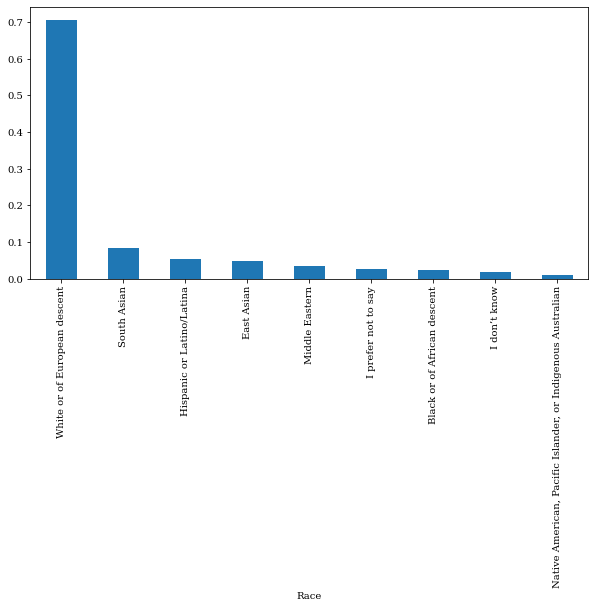

,count
Race,
Black or of African descent,0.023805
East Asian,0.046632
Hispanic or Latino/Latina,0.053446
"Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)",0.008366
Middle Eastern,0.034011
Other,0.043815
South Asian,0.083259
White or of European descent,0.706667


In [43]:
poss_vals = get_possible_values(df2017, 'Race')
props_df2017 = clean_and_plot(df2017, column_name = 'Race', possible_values = poss_vals)
props_df2017.rename({'I don’t know': 'Other', 'I prefer not to say': 'Other'}, inplace = True)
props_df2017.rename({'Native American, Pacific Islander, or Indigenous Australian' : 'Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)'}, inplace = True)
props_df2017 = props_df2017.groupby(['Race'], as_index=True).agg('sum')
props_df2017

### 2018

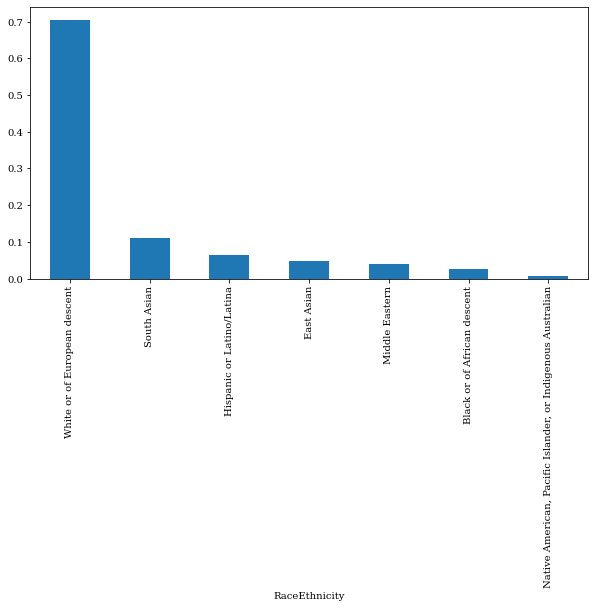

,count
RaceEthnicity,
Black or of African descent,0.026212
East Asian,0.048505
Hispanic or Latino/Latina,0.063835
"Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)",0.007359
Middle Eastern,0.039244
Other,0.000000
South Asian,0.109744
White or of European descent,0.705100


In [44]:
poss_vals = get_possible_values(df2018, 'RaceEthnicity')
props_df2018 = clean_and_plot(df2018, column_name = 'RaceEthnicity', possible_values = poss_vals)
props_df2018.rename({'Native American, Pacific Islander, or Indigenous Australian' : 'Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)'}, inplace = True)
props_df2018 = pd.concat([props_df2018, dfOther]) # Add an empty Other column
props_df2018 = props_df2018.groupby(['RaceEthnicity'], as_index=True).agg('sum')
props_df2018

In [45]:
props_df2018.index == props_df2017.index # Double check that each year now has the same categories

array([ True,  True,  True,  True,  True,  True,  True,  True])

### 2019

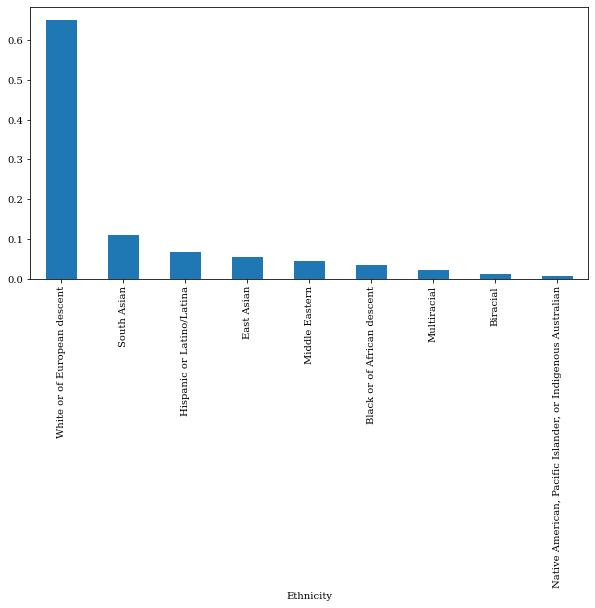

,count
Ethnicity,
Black or of African descent,0.033343
East Asian,0.053962
Hispanic or Latino/Latina,0.065713
"Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)",0.007474
Middle Eastern,0.043485
Other,0.033872
South Asian,0.109895
White or of European descent,0.652256


In [46]:
poss_vals = get_possible_values(df2019, 'Ethnicity')
props_df2019 = clean_and_plot(df2019, column_name = 'Ethnicity', possible_values = poss_vals)
props_df2019.rename({'Native American, Pacific Islander, or Indigenous Australian' : 'Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)'}, inplace = True)
props_df2019.rename({'Biracial': 'Other', 'Multiracial': 'Other'}, inplace = True)
props_df2019 = props_df2019.groupby(['Ethnicity'], as_index=True).agg('sum')
props_df2019

In [47]:
props_df2019.index == props_df2018.index # Double check that each year now has the same categories

array([ True,  True,  True,  True,  True,  True,  True,  True])

### 2020

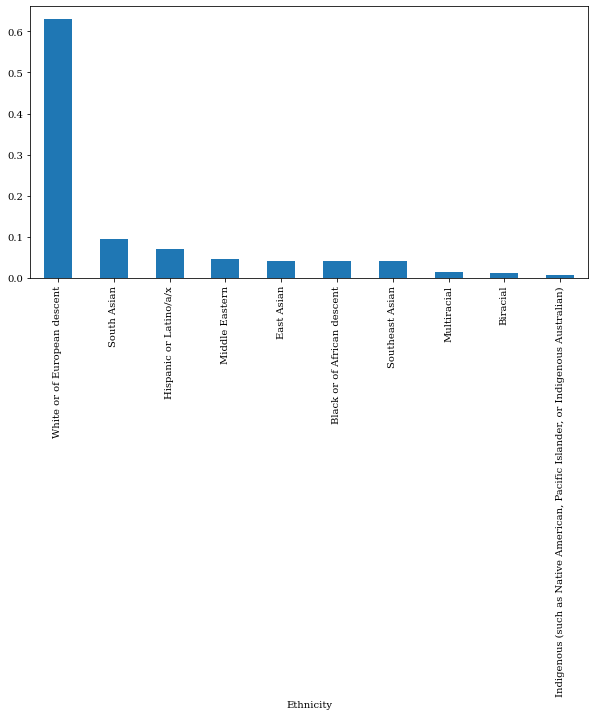

,count
Ethnicity,
Black or of African descent,0.041333
East Asian,0.042536
Hispanic or Latino/Latina,0.069838
"Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)",0.007677
Middle Eastern,0.045543
Other,0.068495
South Asian,0.095556
White or of European descent,0.629022


In [48]:
poss_vals = get_possible_values(df2020, 'Ethnicity')
props_df2020 = clean_and_plot(df2020, column_name = 'Ethnicity', possible_values = poss_vals)
props_df2020.rename({'Biracial': 'Other', 'Multiracial': 'Other', 'Southeast Asian': 'Other', 'Hispanic or Latino/a/x' : 'Hispanic or Latino/Latina'}, inplace = True)
props_df2020 = props_df2020.groupby(['Ethnicity'], as_index=True).agg('sum')
props_df2020

### 2021

In [49]:
props_df2020.index == props_df2019.index # Double check that each year now has the same categories

array([ True,  True,  True,  True,  True,  True,  True,  True])

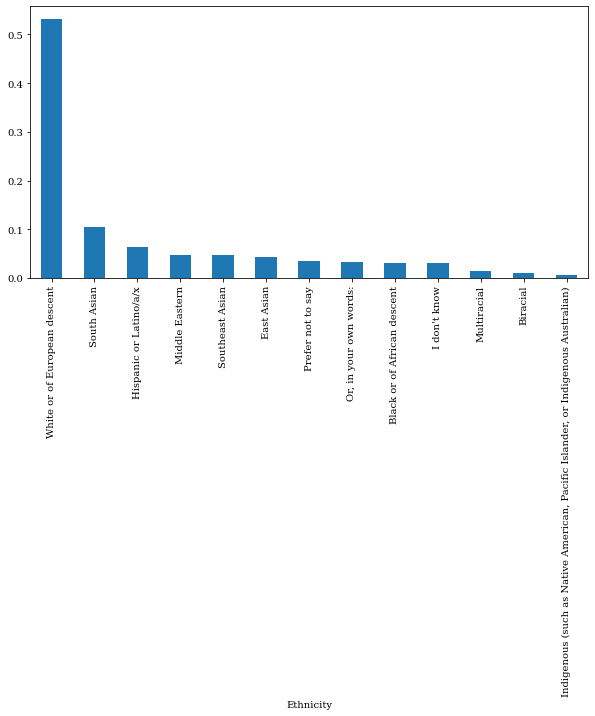

,count
Ethnicity,
Black or of African descent,0.030719
East Asian,0.042716
Hispanic or Latino/Latina,0.063703
"Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)",0.006576
Middle Eastern,0.048286
Other,0.171564
South Asian,0.105379
White or of European descent,0.531057


In [50]:
poss_vals = get_possible_values(df2021, 'Ethnicity')
props_df2021 = clean_and_plot(df2021, column_name = 'Ethnicity', possible_values = poss_vals)
props_df2021.rename({'I don\'t know': 'Other', 'Prefer not to say': 'Other', 'Or, in your own words:':'Other'}, inplace = True)
props_df2021.rename({'Biracial': 'Other', 'Multiracial': 'Other', 'Southeast Asian': 'Other', 'Hispanic or Latino/a/x' : 'Hispanic or Latino/Latina'}, inplace = True)
props_df2021 = props_df2021.groupby(['Ethnicity'], as_index=True).agg('sum')
props_df2021

In [51]:
props_df2021.index == props_df2020.index # Double check that each year now has the same categories

array([ True,  True,  True,  True,  True,  True,  True,  True])

<a name="VisualiseRace"></a>
## Visualise Race/Ethnicity data

In [52]:
props_df2017.rename(columns={"count": "count2017"}, inplace = True)
props_df2018.rename(columns={"count": "count2018"}, inplace = True)
props_df2019.rename(columns={"count": "count2019"}, inplace = True)
props_df2020.rename(columns={"count": "count2020"}, inplace = True)
props_df2021.rename(columns={"count": "count2021"}, inplace = True)

In [53]:
counts_df = props_df2017.join(props_df2018)
counts_df = counts_df.join(props_df2019)
counts_df = counts_df.join(props_df2020)
counts_df = counts_df.join(props_df2021)

In [54]:
counts_df

,count2017,count2018,count2019,count2020,count2021
Race,,,,,
Black or of African descent,0.023805,0.026212,0.033343,0.041333,0.030719
East Asian,0.046632,0.048505,0.053962,0.042536,0.042716
Hispanic or Latino/Latina,0.053446,0.063835,0.065713,0.069838,0.063703
"Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)",0.008366,0.007359,0.007474,0.007677,0.006576
Middle Eastern,0.034011,0.039244,0.043485,0.045543,0.048286
Other,0.043815,0.000000,0.033872,0.068495,0.171564
South Asian,0.083259,0.109744,0.109895,0.095556,0.105379
White or of European descent,0.706667,0.705100,0.652256,0.629022,0.531057


In [55]:
### Make a publication-quality plot for Race

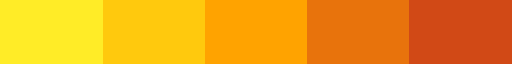

In [56]:
counts_df_to_plot = counts_df[['count2021', 'count2020', 'count2019', 'count2018', 'count2017']]
counts_df_to_plot = counts_df_to_plot.rename(columns = {'count2021':'2021', 'count2020':'2020', 'count2019':'2019', 'count2018':'2018', 'count2017':'2017'})
counts_df_to_plot.rename({'Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)': 'Indigenous'}, inplace = True)
special_palette = ListedColormap(newcolors[::], name='special_palette')
special_palette # Reversing the colors because I want to present 2021 first

In [57]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

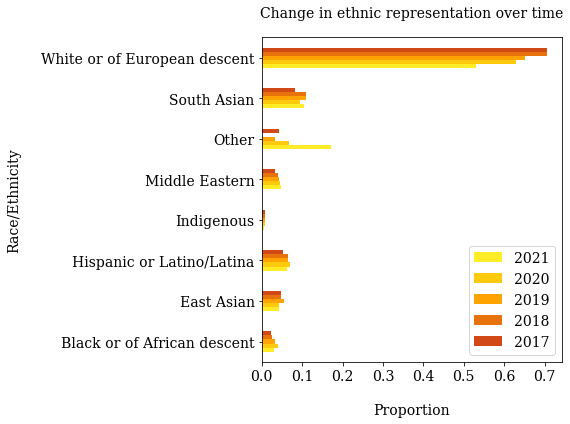

In [58]:
counts_df_to_plot.plot(kind='barh', figsize = ((8,6)), colormap = gold_palette_reversed);
fontsize = 14
plt.legend(fontsize = fontsize)
plt.ylabel('Race/Ethnicity', labelpad = 20, fontsize = fontsize)
plt.xlabel('Proportion', labelpad = 20, fontsize = fontsize)
plt.yticks(fontsize = fontsize, rotation = 0)
plt.xticks(fontsize = fontsize, rotation = 0)
plt.title('Change in ethnic representation over time', fontsize = fontsize, pad = 20)
plt.tight_layout()
plt.savefig('Race-Ethnicity.png')
plt.show()

<a name="PopularProgrammingLanguages"></a>

<a name="PopularProgrammingLanguages"></a>

**CRISP-DM 5. Evaluation (Race/Ethnicity)** 

There has been a drop from 71% dominance of "White or of European descent" in 2017 to only 53% dominance in 2021. 

The next biggest category is "South Asian" which has remainly relatively constant over they period.

The "Other" category has increased in size in 2021.

<a name="PopularProgrammingLanguages"></a>
# Popular Programming Languages

3. Which programming languages have become more or less popular between 2017 – 2021?

<a name="CleanLanguages"></a>
## Clean Languages data

In [59]:
# Subset the data to only the columns we are analysing
df2017 = drop_empty_rows(all_data[0][['WantWorkLanguage']])
df2018 = drop_empty_rows(all_data[1][['LanguageDesireNextYear']])
df2019 = drop_empty_rows(all_data[2][['LanguageDesireNextYear']])
df2020 = drop_empty_rows(all_data[3][['LanguageDesireNextYear']])
df2021 = drop_empty_rows(all_data[4][['LanguageWantToWorkWith']])

From 51392 rows 17621 rows containing null values were dropped, leaving 33771 rows.
From 98855 rows 25611 rows containing null values were dropped, leaving 73244 rows.
From 88883 rows 4795 rows containing null values were dropped, leaving 84088 rows.
From 64461 rows 10348 rows containing null values were dropped, leaving 54113 rows.
From 83439 rows 6618 rows containing null values were dropped, leaving 76821 rows.


In [60]:
# Look at each year individually, and then combine.

<a name="AnalyseLanguages"></a>
## Analyse Languages data

### 2017

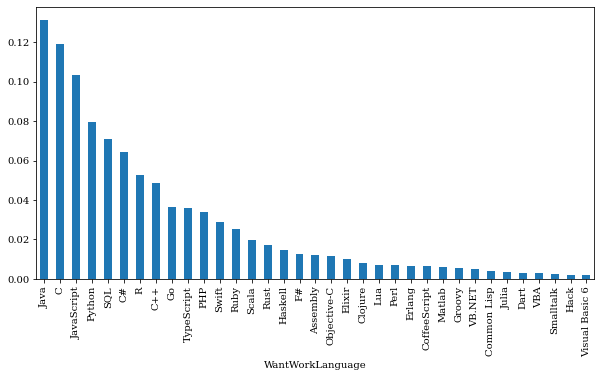

In [61]:
possible_values = get_possible_values(df2017, 'WantWorkLanguage')
props_df2017 = clean_and_plot(df2017, column_name = 'WantWorkLanguage', possible_values = possible_values)

### 2018

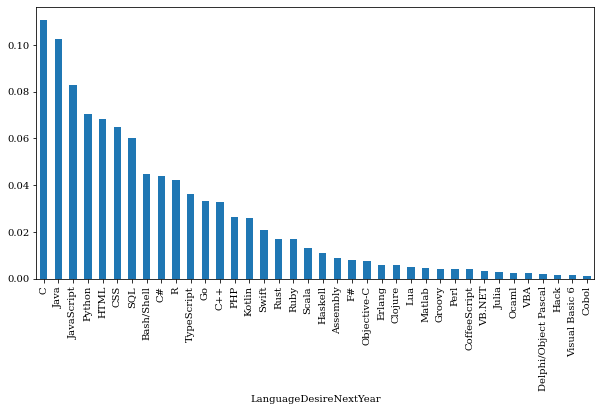

In [62]:
possible_values = get_possible_values(df2018, 'LanguageDesireNextYear')
props_df2018 = clean_and_plot(df2018, column_name = 'LanguageDesireNextYear', possible_values = possible_values)

### 2019

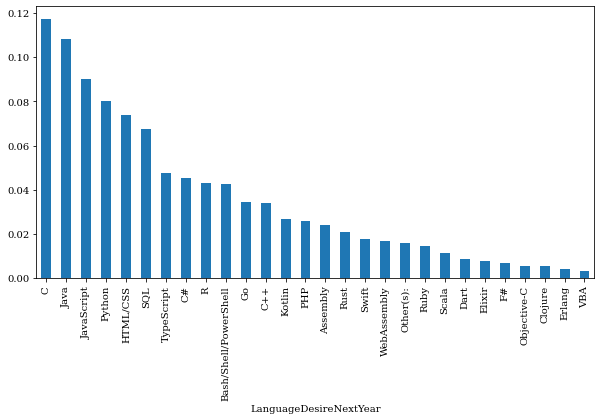

In [63]:
possible_values = get_possible_values(df2019, 'LanguageDesireNextYear')
props_df2019 = clean_and_plot(df2019, column_name = 'LanguageDesireNextYear', possible_values = possible_values)

### 2020

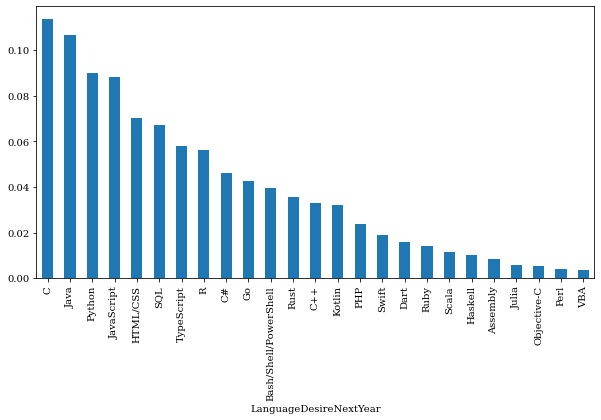

In [64]:
possible_values = get_possible_values(df2020, 'LanguageDesireNextYear')
props_df2020 = clean_and_plot(df2020, column_name = 'LanguageDesireNextYear', possible_values = possible_values)

### 2021

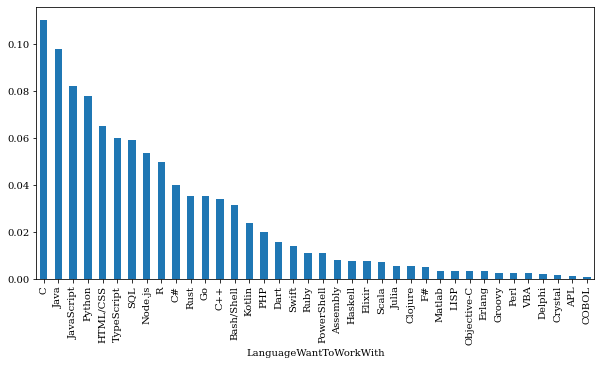

In [65]:
possible_values = get_possible_values(df2021, 'LanguageWantToWorkWith')
props_df2021 = clean_and_plot(df2021, column_name = 'LanguageWantToWorkWith', possible_values = possible_values)

<a name="VisualiseLanguages"></a>
## Visualise Languages data

In [66]:
props_df2017.rename(columns={"count": "2017"}, inplace = True)
props_df2018.rename(columns={"count": "2018"}, inplace = True)
props_df2019.rename(columns={"count": "2019"}, inplace = True)
props_df2020.rename(columns={"count": "2020"}, inplace = True)
props_df2021.rename(columns={"count": "2021"}, inplace = True)

In [67]:
language_counts = props_df2017.join(props_df2018)
language_counts = language_counts.join(props_df2019)
language_counts = language_counts.join(props_df2020)
language_counts = language_counts.join(props_df2021)

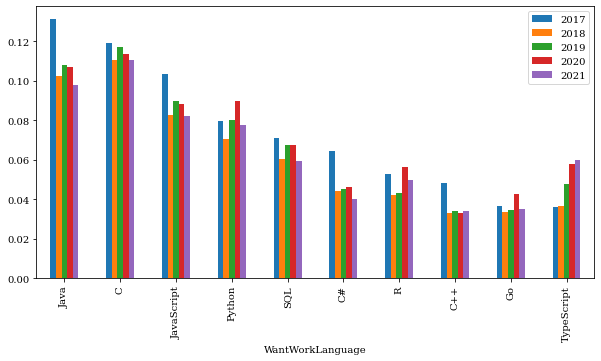

In [68]:
language_counts.head(10).plot(kind='bar', figsize = ((10,5)));

### Make a publication-quality plot for popular programming languages

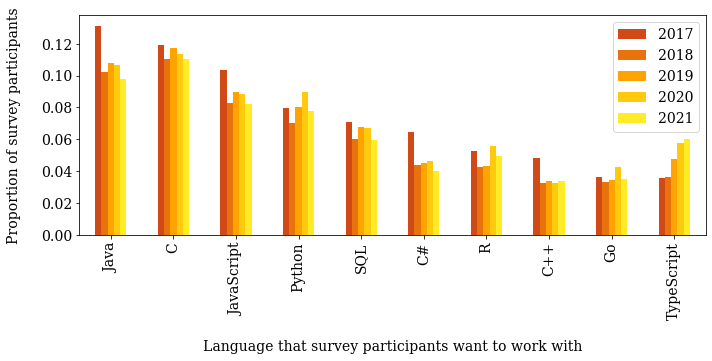

In [69]:
language_counts.sort_values(by = '2017', axis=0, ascending = False).head(10).plot(kind='bar', figsize = ((10,5)), colormap = gold_palette);
fontsize = 14
plt.xlabel('Language that survey participants want to work with', labelpad = 20, fontsize = fontsize)
plt.ylabel('Proportion of survey participants', labelpad = 20, fontsize = fontsize)
#plt.title('Popular programming languages', fontsize = fontsize)
plt.xticks(fontsize = fontsize); plt.yticks(fontsize = fontsize)
plt.legend(fontsize = fontsize)
plt.tight_layout()
plt.savefig('Languages.png')
plt.show()

### Make a "Top 10" table for blogpost

In [70]:
languages2017 = language_counts.sort_values(by = '2017', ascending = False)
top10_in_2017 = languages2017.head(10).index
languages2021 = language_counts.sort_values(by = '2021', ascending = False)
top10_in_2021 = languages2021.head(10).index
data = np.array([top10_in_2017.values, top10_in_2021.values]).transpose()
df = pd.DataFrame(data, columns = ['2017', '2021'], index = np.arange(1, 11, 1))
df

,2017,2021
1,Java,C
2,C,Java
3,JavaScript,JavaScript
4,Python,Python
5,SQL,TypeScript
6,C#,SQL
7,R,R
8,C++,C#
9,Go,Rust
10,TypeScript,Go


In [71]:
language_counts.head(10)

,2017,2018,2019,2020,2021
WantWorkLanguage,,,,,
Java,0.131235,0.102294,0.108215,0.106772,0.098033
C,0.119135,0.110624,0.117103,0.113427,0.110470
JavaScript,0.103326,0.082713,0.089886,0.088287,0.082402
Python,0.079550,0.070520,0.080376,0.089953,0.077773
SQL,0.070987,0.060233,0.067438,0.067325,0.059296
C#,0.064469,0.043908,0.045102,0.046099,0.040077
R,0.052603,0.042355,0.043186,0.056128,0.049764
C++,0.048394,0.032876,0.033866,0.032890,0.033953
Go,0.036516,0.033393,0.034275,0.042495,0.035154


**CRISP-DM 5. Evaluation (Languages)** 

In 2017, Java was in number 1 position with 13% of developers wanting to use it; by 2021 it had dropped to number 2 position with the corresponding percentage dropping to 10%.

The situation is reversed for C. In 2017, C was in number 2 position with 12% of developers wanting to use it; by 2021 it had risen to number 1 position with the corresponding percentage increasing to 11%.

Note however that these two are really neck and neck, with only 1 percent point difference between them, which may not be statistically significant.

JavaScript and Python remain in third and fourth positions throughout.


**CRISP-DM 6. Deployment**

The results found in our data analysis are communicated in a [medium.com blogpost](https://medium.com/@renju.s.mathew/the-stackoverflow-yearly-survey-a-treasure-trove-of-insight-938aa4ac46b3).

In summary, the following three answers are described in that article:
    
1. In 2017, Java was the most popular programming language and C was in second place; in 2021, C and Java have swapped positions.
2. The gender representation has remained almost the same over the five years, with a 91% male representation.
3. The race/ethnicity representation has changed over the five years, with "White or of European descent" decreasing from 71% to 53%.